In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import graycode
import cmath

In [2]:
def f(x,y):
    return 2*np.cos(4*np.pi*x+2*np.pi*y)+np.sin(2*np.pi*x+4*np.pi*y)

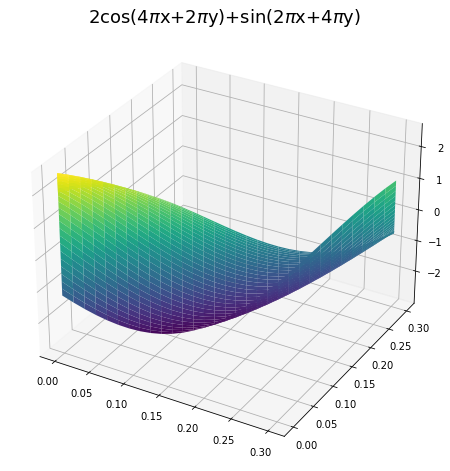

In [7]:
x=np.linspace(0,.3,2**5)
y=np.linspace(0,.3,2**5)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z,100)
ax.plot_surface(x, y, f(X,Y), rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.set_title("2cos(4$\pi$x+2$\pi$y)+sin(2$\pi$x+4$\pi$y)", fontsize=18);
#ax.set_title('surface');

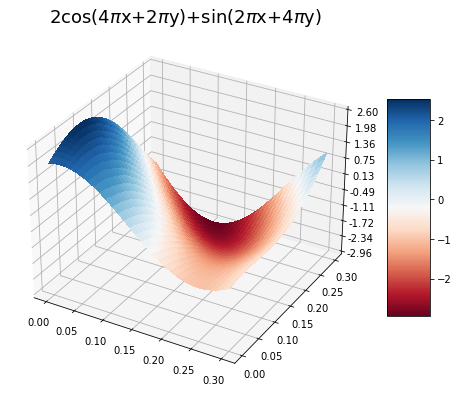

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("2cos(4$\pi$x+2$\pi$y)+sin(2$\pi$x+4$\pi$y)", fontsize=18);
plt.show()

In [66]:
m = 2  # No. of qubits to which uniformly controlled rotations are applied. 
M = 2**m # No. of cos and sin terms in the Fourier series. 

In [67]:
akj=np.zeros(((M)**2))
akj=akj.reshape(M,M)
bkj=np.zeros(((M)**2))
bkj=bkj.reshape(M,M)

for k in range(M):
    for j in range(M):
        if k==2 and j==1:
            akj[k,j]=2
for k in range(M):
    for j in range(M):
        if k==1 and j==2:
            bkj[k,j]=1

In [68]:
F2xy=0 
                     
for k in range(M):
    for j in range(M):
        F2xy+= akj[k,j]*np.cos(2*np.pi*k*X+2*np.pi*j*Y) + bkj[k,j]*np.sin(2*np.pi*k*X+2*np.pi*j*Y)


In [69]:
len(F2xy)

32

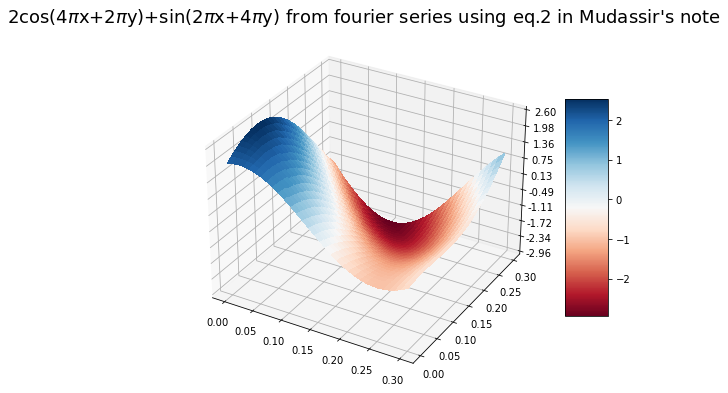

In [70]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, F2xy, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("2cos(4$\pi$x+2$\pi$y)+sin(2$\pi$x+4$\pi$y) from fourier series using eq.2 in Mudassir's note", fontsize=18);
plt.show()

In [82]:
F3xy=0 
                     
for k in range(M):
    for j in range(M):
        F3xy+= (akj[k,j]+1j*bkj[k,j])*np.exp(-1j*(2*np.pi*k*X+2*np.pi*j*Y))
        #cos(2*np.pi*k*x+2*np.pi*j*y) + Bkj[k,j]*np.cos(2*np.pi*k*x-2*np.pi*j*y)


In [83]:
len(F3xy[0])

32

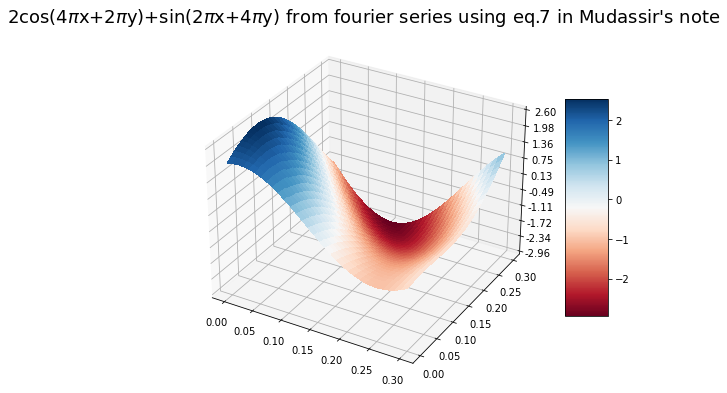

In [85]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, np.real(F3xy), rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("2cos(4$\pi$x+2$\pi$y)+sin(2$\pi$x+4$\pi$y) from fourier series using eq.7 in Mudassir's note", fontsize=18);
plt.show()

In the below cell we are calculating $\theta_{AB}$ such that we can apply the rotation $Ry(2\theta_{AB})$

In [86]:
psi_A=[]
psi_B=[]

for k in range(M):
    for j in range(M):
        psi_A.append(np.abs(Akj[k,j])**2)
psi_A=np.sqrt(np.sum(psi_A))

for k in range(M):
    for j in range(M):
        psi_B.append(np.abs(Bkj[k,j])**2)
psi_B=np.sqrt(np.sum(psi_B))

In [87]:
theta_AB=np.arctan(np.abs(psi_B)/np.abs(psi_A))
theta_AB

0.0

In [88]:
#calculating norm of the state

psi_F=0
psi_F=np.sqrt(np.abs(psi_A)**2+np.abs(psi_B)**2)
psi_F # normalization constant of the state

2.23606797749979

In the below cell we are converting the 2D arrays $A_{kj},B_{kj}$ to 1D array $\psi_{A_P}$ and $\psi_{B_P}$ such that we can insert those parameters into the quantum
circuit.

In [89]:
(Akj)

tensor([[0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 2., 0., 0.],
        [0., 0., 0., 0.]], requires_grad=True)

In [90]:
m = 2  # No. of qubits to which uniformly controlled rotations are applied. 
M = 2**m # No. of cos and sin terms in the Fourier series. 

psi_Ap=[]

for j in range(M):
    for k in range(M):
        psi_Ap.append(Akj[j,k])
        
psi_Bp=[]

for j in range(0,M):
    for k in range(0,M):
        psi_Bp.append(Bkj[j,k])

In [91]:
len(psi_Bp)

16

In [92]:
def find_alphas(target):
    
    n = int(np.log(len(target))/np.log(2))
    
    # We first calculate alpha^{y} using
    # Eq(8) of 0407010.
    alphas_y = []
    
    for j in range(n):
        alpha_j = []
        
        for mu in range(2**(n-j-1)):
            
            num = 0
            for l in range(2**j):
                num = num + np.abs(target[(2*mu+1)*(2**(j))+l])**2
            num = np.sqrt(num)
            
            den = 0
            for l in range(2**(j+1)):
                den = den + np.abs(target[(mu)*(2**(j+1))+l])**2
            den = np.sqrt(den)
            
            if (den<num):
                raise ValueError("something is not right. Argument of arcsin has to be less than 1.")
            elif den==num:
                ratio = 1
            else:
                ratio = num/den
            
            alpha_j.append(2*np.arcsin(ratio))
            
        alphas_y.append(alpha_j)
    
    # We now calculate the alpha^{z} using
    # Eq(5) of 0407010.
    alphas_z = []
    phases = [cmath.phase(t) for t in target]
    
    for j in range(n):
        alpha_j = []
        
        for mu in range(2**(n-j-1)):
            
            sum = 0
            for l in range(2**j):
                sum = sum + (phases[(2*mu+1)*(2**j)+l]-phases[(2*mu)*(2**j)+l])
            sum = sum/(2**j)
            
            alpha_j.append(sum)
        
        alphas_z.append(alpha_j)
    
    # We now calculate the global phase
    # as defined in Eq(7) of 0407010.
    
    global_phase = 2*np.mean(phases)
    
    return alphas_y, alphas_z, global_phase
    

def find_thetas(alphas):
    
    # We calculate thetas using
    # Eq(3) of 0407101.
    
    thetas = []
    
    for alpha in alphas:
        
        theta = []
        
        for i in range(len(alpha)):
            theta_i = 0
            
            for j in range(len(alpha)):
                theta_i = theta_i + M(i,j)*alpha[j]
            theta_i = theta_i/len(alpha)
            
            theta.append(theta_i)
        
        thetas.append(theta)
    
    return thetas

def M(i,j):
    
    # This calculates the matrix M
    # defined in Eq(3) of 0407101.
    # However, our definition is different by a factor of 2^{-k}. 
    
    bj = bin(j)[2:]
    bj_rev = bj[::-1]
    gi = bin(graycode.tc_to_gray_code(i))[2:]
    gi_rev = gi[::-1]
    
    mij = 0
    for x,y in zip(bj_rev,gi_rev):
        mij = mij + int(x)*int(y)
    
    return (-1)**mij

def cnot_position(r):
    
    g1 = bin(graycode.tc_to_gray_code(r))[2:]
    g2 = bin(graycode.tc_to_gray_code(r-1))[2:]
    
    if len(g2)<len(g1):
        g2 = '0' + g2
    
    g1_rev = g1[::-1]
    g2_rev = g2[::-1]
    
    for p in range(len(g1)):
        if g1_rev[p] != g2_rev[p]:
            return p+1


In [93]:
def UCRot(axes,wires,theta):   # Uniformly controlled rotation from 0404089 and 0407010
    
    # wires is the list of wires on which UCRot is acting.
    
    if axes == 'y':
        rot = qml.RY
    elif axes == 'z':
        rot = qml.RZ
    else:
        raise ValueError("only y or z axes are allowed.")
    
    if (len(theta)!=(2**(len(wires)-1))):
        raise ValueError("something is not right.")
        
    wires.reverse()
    
    for r in range(len(theta)-1):
        
        rot(-theta[r],wires=wires[0])   
        #We took -theta because RY or RZ definition
        #in the paper is different from that in pennylane
        qml.CNOT(wires=[wires[cnot_position(r+1)], wires[0]])
    
    
    r = len(theta)-1
    rot(-theta[r],wires=wires[0])
    if r>0:
        qml.CNOT(wires=[wires[-1],wires[0]])
        
def UCRot_inv(axes,wires,theta):
    
    # wires is the list of wires on which UCRot is acting.
    
    if axes == 'y':
        rot = qml.RY
    elif axes == 'z':
        rot = qml.RZ
    else:
        raise ValueError("only y or z axes are allowed.")
    
    if (len(theta)!=(2**(len(wires)-1))):
        raise ValueError("something is not right.")
        
    wires.reverse()
    
    r = len(theta)-1
    if r>0:
        qml.CNOT(wires=[wires[-1],wires[0]])
    rot(theta[r],wires=wires[0])
    
    rs = [(len(theta)-2-r) for r in range(len(theta)-1)]
    for r in rs:
        qml.CNOT(wires=[wires[cnot_position(r+1)], wires[0]])
        rot(theta[r],wires=wires[0])   

In [94]:
def QFT_inverse(wires):
    
    for q in range(int(len(wires)/2)):
        qml.SWAP(wires=[wires[q],wires[len(wires)-1-q]])
    
    for q in range(len(wires)):
        QFT_inverse_partial(wires[(len(wires)-1-q):])

def QFT_inverse_partial(wires):
    
    qs = [(len(wires)-w) for w in range(1,len(wires))]
    for q in qs:
        phi_q = (2*np.pi)/(2**(q+1))
        qml.ControlledPhaseShift(-phi_q,wires=[wires[q],wires[0]])
    
    qml.Hadamard(wires=wires[0])  

In [95]:
nq = 10 # Total no. of qubits
dev = qml.device("lightning.qubit", wires=nq)

In [157]:
def circuit_A(target_A,wires):
    
        alphas_y_A, alphas_z_A, phase_A = find_alphas(target_A)

        thetas_y_A = find_thetas(alphas_y_A)
        thetas_z_A = find_thetas(alphas_z_A)

        total_wires = len(wires)

        m1 = len(thetas_y_A)
        m2 = total_wires - m1  # Remaining wires.

        # starting of control U_A............................................................


        

            # then the Rz gate
        #qml.ctrl(qml.RZ(-phase_A,wires=[3]),control=0)
        qml.RZ(-phase_A,wires=[3])

        for w in range(int(m1/2)):

            ws = [(int(m2/2)+q) for q in range(w+1)]
            (UCRot('y',ws,thetas_y_A[m1-1-w]))
        ws = [3,4,8]                                                            #[(int(m2/2)+q) for q in range(w+1)]
        (UCRot('y',ws,thetas_y_A[1]))  
        ws = [3,4,8,9]                                                          #[(int(m2/2)+q) for q in range(w+1)]
        (UCRot('y',ws,thetas_y_A[0]))  

        for w in range(int(m1/2)):

            ws = [(int(m2/2)+q) for q in range(w+1)]
            (UCRot('z',ws,thetas_z_A[m1-1-w]))
        ws = [3,4,8]                                                            #[(int(m2/2)+q) for q in range(w+1)]
        (UCRot('z',ws,thetas_z_A[1]))  
        ws = [3,4,8,9]                                                          #[(int(m2/2)+q) for q in range(w+1)]
        (UCRot('z',ws,thetas_z_A[0]))  

       
        
        #QFT_inverse([3,4,8,9])

        # end of control U_A................................................................

In [163]:
@qml.qnode(dev)
def final_circuit(target_A,wires):
    
        # applying Ry(theta_AB)
        #qml.RY(2*theta_AB,wires=[0])
        
        #qml.PauliX(wires=0)
        circuit_A(target_A,wires)
        #qml.PauliX(wires=0)

     # the 4 CNOT gates after U_A and U_B
        #for i in range(4):
        #    qml.CNOT(wires=[0,i+1])
    
        QFT_inverse(range(0,5))
        QFT_inverse(range(5,10))
    
        return qml.state()

In [164]:
target_state_A = psi_Ap #psi_Ap,psi_Bp are the two target states target a and target b 
                                                        # no need to specify them separately
norm_target_state_A = np.linalg.norm(target_state_A)
normalized_target_state_A = target_state_A/norm_target_state_A


In [165]:
fx = (2**nq)*(psi_F)*np.real(final_circuit(normalized_target_state_A,range(nq)))

In [166]:
(fx)=fx.reshape(32,32)#/np.linalg.norm(fx.reshape(32,32))

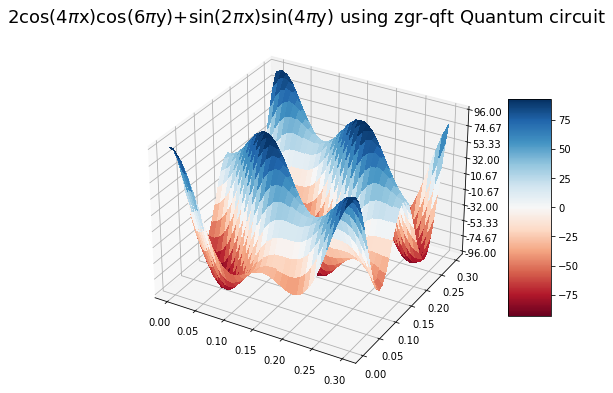

In [167]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, fx, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("2cos(4$\pi$x)cos(6$\pi$y)+sin(2$\pi$x)sin(4$\pi$y) using zgr-qft Quantum circuit", fontsize=18);
plt.show()

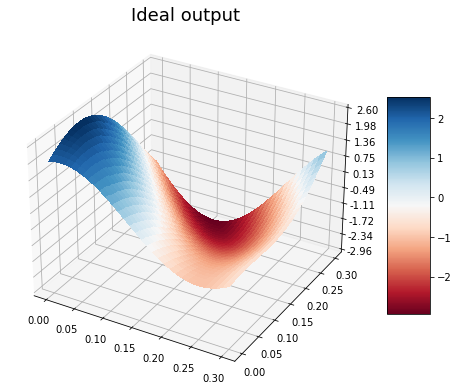

In [129]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, np.real(F3xy), rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Ideal output", fontsize=18);
plt.show()

In [211]:
'''
@qml.qnode(dev)
def circuit(target_A,target_B,wires):
    
        
        
        alphas_y_A, alphas_z_A, phase_A = find_alphas(target_A)

        thetas_y_A = find_thetas(alphas_y_A)
        thetas_z_A = find_thetas(alphas_z_A)
    
        
    
        alphas_y_B, alphas_z_B, phase_B = find_alphas(target_B)

        thetas_y_B = find_thetas(alphas_y_B)
        thetas_z_B = find_thetas(alphas_z_B)
    
        total_wires = len(wires)

        m1 = len(thetas_y_B)
        m2 = total_wires - m1  # Remaining wires.

    
    
    
        # applying Ry(theta_AB)
        qml.RY(2*theta_AB,wires=[0])

       
        # starting of control U_A............................................................
    
   
        
        
        qml.PauliX(wires=0)

            # then the Rz gate
        qml.ctrl(qml.RZ(-phase_A,wires=[3]),control=0)

        for w in range(int(m1/2)):

            ws = [(int(m2/2)+q) for q in range(w+1)]
            qml.ctrl(UCRot_inv('y',ws,thetas_y_A[m1-1-w]),control=0)
        ws = [3,4,8]#[(int(m2/2)+q) for q in range(w+1)]
        qml.ctrl(UCRot_inv('y',ws,thetas_y_A[1]),control=0)  
        ws = [3,4,8,9]#[(int(m2/2)+q) for q in range(w+1)]
        qml.ctrl(UCRot_inv('y',ws,thetas_y_A[0]),control=0)  

        for w in range(int(m1/2)):

            ws = [(int(m2/2)+q) for q in range(w+1)]
            qml.ctrl(UCRot_inv('z',ws,thetas_z_A[m1-1-w]),control=0)
        ws = [3,4,8]#[(int(m2/2)+q) for q in range(w+1)]
        qml.ctrl(UCRot_inv('z',ws,thetas_z_A[1]),control=0)  
        ws = [3,4,8,9]#[(int(m2/2)+q) for q in range(w+1)]
        qml.ctrl(UCRot_inv('z',ws,thetas_z_A[0]),control=0)  

        qml.PauliX(wires=0)

        # end of control U_A................................................................

    # starting of control U_B...........................................................
        
        

        # then the Rz gate
        qml.ctrl(qml.RZ(-phase_B,wires=[3]),control=0)

        for w in range(int(m1/2)):

            ws = [(int(m2/2)+q) for q in range(w+1)]
            qml.ctrl(UCRot_inv('y',ws,thetas_y_B[m1-1-w]),control=0)
        ws = [3,4,8]#[(int(m2/2)+q) for q in range(w+1)]
        qml.ctrl(UCRot_inv('y',ws,thetas_y_B[1]),control=0)  
        ws = [3,4,8,9]#[(int(m2/2)+q) for q in range(w+1)]
        qml.ctrl(UCRot_inv('y',ws,thetas_y_B[0]),control=0)  

        for w in range(int(m1/2)):

            ws = [(int(m2/2)+q) for q in range(w+1)]
            qml.ctrl(UCRot_inv('z',ws,thetas_z_B[m1-1-w]),control=0)
        ws = [3,4,8]#[(int(m2/2)+q) for q in range(w+1)]
        qml.ctrl(UCRot_inv('z',ws,thetas_z_B[1]),control=0)  
        ws = [3,4,8,9]#[(int(m2/2)+q) for q in range(w+1)]
        qml.ctrl(UCRot_inv('z',ws,thetas_z_B[0]),control=0)  

        # end of control U_B................................................................

    # the 4 CNOT gates after U_A and U_B
        for i in range(4):
            qml.CNOT(wires=[0,i+1])
    
        QFT_inverse(range(0,5))
        QFT_inverse(range(5,10))
    
        return qml.state()
'''

"\n@qml.qnode(dev)\ndef circuit(target_A,target_B,wires):\n    \n        \n        \n        alphas_y_A, alphas_z_A, phase_A = find_alphas(target_A)\n\n        thetas_y_A = find_thetas(alphas_y_A)\n        thetas_z_A = find_thetas(alphas_z_A)\n    \n        \n    \n        alphas_y_B, alphas_z_B, phase_B = find_alphas(target_B)\n\n        thetas_y_B = find_thetas(alphas_y_B)\n        thetas_z_B = find_thetas(alphas_z_B)\n    \n        total_wires = len(wires)\n\n        m1 = len(thetas_y_B)\n        m2 = total_wires - m1  # Remaining wires.\n\n    \n    \n    \n        # applying Ry(theta_AB)\n        qml.RY(2*theta_AB,wires=[0])\n\n       \n        # starting of control U_A............................................................\n    \n   \n        \n        \n        qml.PauliX(wires=0)\n\n            # then the Rz gate\n        qml.ctrl(qml.RZ(-phase_A,wires=[3]),control=0)\n\n        for w in range(int(m1/2)):\n\n            ws = [(int(m2/2)+q) for q in range(w+1)]\n           

In [26]:
range(0,5)

range(0, 5)